# 统计不同模型下每类预测的数量，导出到csv

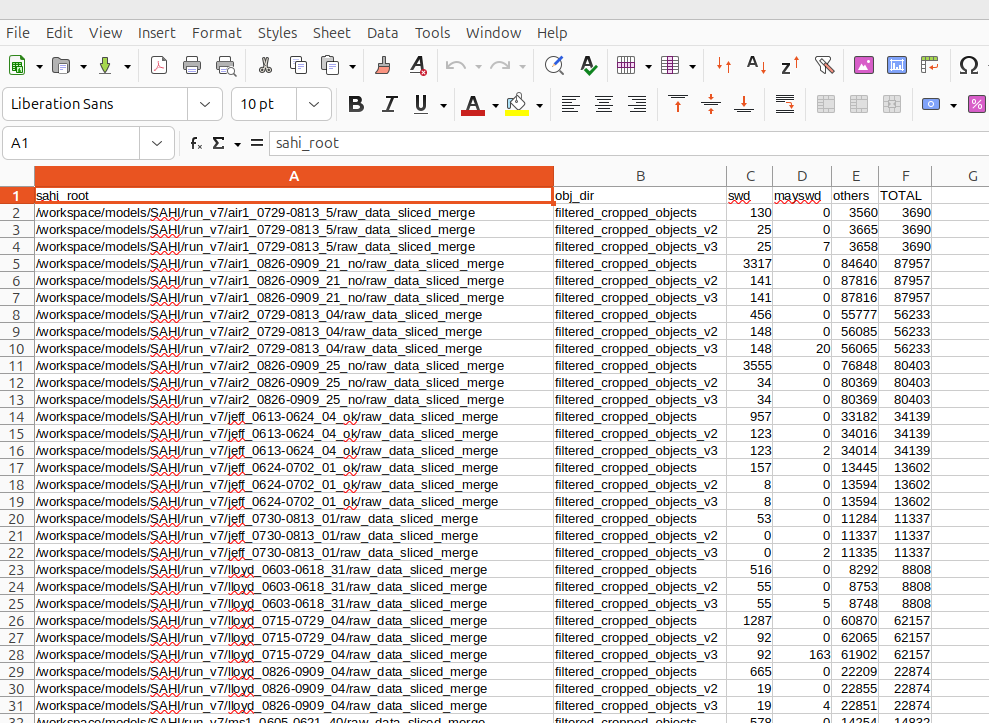

In [ ]:
#!/usr/bin/env python3
from pathlib import Path
import csv

CLASSES = ["swd", "mayswd", "others"]  # 想加/改类别就在这里改

def count_classes_to_dict(base_dir: Path, classes=CLASSES):
    """
    统计 base_dir 下每个类别文件夹中的文件数；不存在则记为 0。
    返回：({class: count, ...}, total)
    """
    counts = {}
    total = 0
    for c in classes:
        dir_path = base_dir / c
        if dir_path.is_dir():
            n = sum(1 for p in dir_path.iterdir() if p.is_file())
        else:
            n = 0
        counts[c] = n
        total += n
    return counts, total

def process_sahi_directory_to_rows(sahi_base_path: str, classes=CLASSES):
    """
    遍历 sahi_base_path 下所有 **/raw_data_sliced_merge 中的 filtered_cropped_objects* 目录，
    返回用于写 CSV 的 rows（列表的字典）。
    """
    sahi_path = Path(sahi_base_path)
    rows = []

    for root_dir in sahi_path.glob("**/raw_data_sliced_merge"):
        for obj_dir in root_dir.glob("filtered_cropped_objects*"):
            if not obj_dir.is_dir():
                continue
            counts, total = count_classes_to_dict(obj_dir, classes)
            row = {
                "sahi_root": str(root_dir),
                "obj_dir": obj_dir.name,
                **{c: counts.get(c, 0) for c in classes},
                "TOTAL": total,
            }
            rows.append(row)

    # 可选：排序让结果更整齐
    rows.sort(key=lambda r: (r["sahi_root"], r["obj_dir"]))
    return rows

def write_rows_to_csv(rows, output_csv_path: Path, classes=CLASSES):
    output_csv_path.parent.mkdir(parents=True, exist_ok=True)
    fieldnames = ["sahi_root", "obj_dir", *classes, "TOTAL"]
    with output_csv_path.open("w", newline="", encoding="utf-8") as f:
        writer = csv.DictWriter(f, fieldnames=fieldnames)
        writer.writeheader()
        writer.writerows(rows)

def main():
    # SAHI 基础路径
    sahi_base_path = "/workspace/models/SAHI/run_v7"
    # 输出 CSV 路径（默认写到 sahi_base_path 下）
    output_csv = Path(sahi_base_path) / "class_counts.csv"

    rows = process_sahi_directory_to_rows(sahi_base_path, CLASSES)
    write_rows_to_csv(rows, output_csv, CLASSES)
    print(f"[OK] 写入完成：{output_csv}（共 {len(rows)} 行）")

if __name__ == "__main__":
    main()
